In [3]:
import os

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from huggingface_hub import hf_hub_download
from PIL import Image
from sklearn.metrics import accuracy_score
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from transformers import (SegformerForSemanticSegmentation,
                          SegformerImageProcessor)

from transformers import AutoFeatureExtractor

In [50]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, image_processor, train=True):

        self.root_dir = root_dir
        self.image_processor = image_processor
        self.train = train

        sub_path = "train" if self.train else "valid"

        fnames = []
        with open(os.path.join(self.root_dir, sub_path, 'list.txt'), 'r') as f:
            for line in f:
                fnames.append(line.strip())

        self.images = sorted(
            [os.path.join(self.root_dir, sub_path, 'image', fname)
             for fname in fnames if fname.endswith('png')])
        self.annotations = sorted(
            [os.path.join(self.root_dir, sub_path, 'gt', fname)
             for fname in fnames if fname.endswith('png')])

        assert len(self.images) == len(self.annotations), "There must be as \
          many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = torch.Tensor(np.array(Image.open(self.images[idx]).convert('RGB')))
        image_tensor = image.permute(2, 0, 1)
        segmentation_map = torch.Tensor(np.array(Image.open(self.annotations[idx]).convert('L')))
        segmentation_map = segmentation_map == 255

        # randomly crop + pad both image and segmentation map to same size
        # encoded_inputs = self.image_processor(image, segmentation_map,
        #                                       return_tensors="pt")        
        # for k, v in encoded_inputs.items():
        #     encoded_inputs[k].squeeze_()  # remove batch dimension

        

        # return encoded_inputs
        return {"pixel_values": image_tensor, "labels": torch.tensor(segmentation_map.clone().detach(), dtype=torch.long)}

In [51]:
############################################################################
# Data
############################################################################

root_dir = '../data/ovaskainen23'
image_processor = SegformerImageProcessor(reduce_labels=True)

train_dataset = SemanticSegmentationDataset(
  root_dir=root_dir, image_processor=image_processor)
valid_dataset = SemanticSegmentationDataset(
  root_dir=root_dir, image_processor=image_processor, train=False)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

"""Let's verify a random example:"""

encoded_inputs = train_dataset[7453]
print(encoded_inputs["pixel_values"].shape)
print(encoded_inputs["labels"].shape)

encoded_inputs["labels"]
print(encoded_inputs["labels"].squeeze().unique())

Number of training examples: 7484
Number of validation examples: 1664
torch.Size([3, 256, 256])
torch.Size([256, 256])
tensor([0, 1])


/tmp/43872167/ipykernel_2480395/3542152132.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"pixel_values": image_tensor, "labels": torch.tensor(segmentation_map.clone().detach(), dtype=torch.long)}


In [52]:
encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [53]:
model_checkpoint = "nvidia/mit-b0"

In [54]:
feature_extractor = AutoFeatureExtractor.from_pretrained(model_checkpoint, size=(256, 256))

/work/FAC/FGSE/ISTE/asamsu/detect/venv_pytorch_gpu/lib/python3.9/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


SegformerFeatureExtractor {
  "_valid_processor_keys": [
    "images",
    "segmentation_maps",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_reduce_labels",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerFeatureExtractor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 256,
    "width": 256
  }
}

In [55]:
# """Next, we define corresponding dataloaders."""


# train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=4)

# batch = next(iter(train_dataloader))

# for k, v in batch.items():
#     print(k, v.shape)

# batch["labels"].shape

# batch['labels'].sum() / 255

In [56]:
label2id = {'non_frac': 0, 'frac': 1}
id2label = {0: 'non_frac', 1: 'frac'}

In [57]:
############################################################################
# Model
############################################################################

model = SegformerForSemanticSegmentation.from_pretrained(model_checkpoint,
                                                         num_labels=2,
                                                         id2label=id2label,
                                                         label2id=label2id,)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [58]:
batch_size = 8
metric_name = "f1"
epochs = 50

In [59]:
from transformers import TrainingArguments, Trainer

In [60]:
# epochs = 50
# lr = 0.00006
# batch_size = 8

# hub_model_id = "segformer-b0-finetuned-segments-sidewalk-2"

# training_args = TrainingArguments(
#     f"segFormer-test1",
#     learning_rate=lr,
#     num_train_epochs=epochs,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     save_total_limit=3,
#     evaluation_strategy="steps",
#     save_strategy="steps",
#     save_steps=20,
#     eval_steps=20,
#     logging_steps=1,
#     eval_accumulation_steps=5,
#     load_best_model_at_end=True,
#     push_to_hub=True,
#     hub_model_id=hub_model_id,
#     hub_strategy="end",
# )

In [61]:
args = TrainingArguments(
    f"segFormer-test1",
    evaluation_strategy = "steps",
    save_strategy = "steps",
    eval_steps=100,
    save_steps=1000,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    load_best_model_at_end=True,
    # metric_for_best_model=metric_name,
    #push_to_hub=True,
)

In [63]:
import torch
from torch import nn
import evaluate

metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=333,
            # reduce_labels=feature_extractor.do_reduce_labels,
            reduce_labels=False,
        )
    
    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})
      
    # metrics.update({f"accuracy_{id2label[i]}": v for i, v in zip(id2label.keys(), per_category_accuracy)})
    # metrics.update({f"iou_{id2label[i]}": v for i, v in zip(id2label.keys(), per_category_iou)})
    
    return metrics

In [64]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [65]:
trainer.train()

/tmp/43872167/ipykernel_2480395/3542152132.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"pixel_values": image_tensor, "labels": torch.tensor(segmentation_map.clone().detach(), dtype=torch.long)}


Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Non Frac,Accuracy Frac,Iou Non Frac,Iou Frac
100,No log,0.390899,0.490963,0.535808,0.957319,0.966120,0.105495,0.957273,0.024652
200,No log,0.267100,0.495119,0.500234,0.989590,0.999807,0.000660,0.989590,0.000648
300,No log,0.199477,0.495061,0.500176,0.989588,0.999806,0.000545,0.989588,0.000535
400,No log,0.153124,0.494887,0.500000,0.989774,1.000000,0.000000,0.989774,0.000000
500,0.323900,0.114837,0.494887,0.500000,0.989774,1.000000,0.000000,0.989774,0.000000
600,0.323900,0.100140,0.494887,0.500000,0.989774,1.000000,0.000000,0.989774,0.000000
700,0.323900,0.085451,0.494887,0.500000,0.989774,1.000000,0.000000,0.989774,0.000000
800,0.323900,0.085447,0.494887,0.500000,0.989774,1.000000,0.000000,0.989774,0.000000
900,0.323900,0.071578,0.494887,0.500000,0.989774,1.000000,0.000000,0.989774,0.000000
1000,0.109300,0.068070,0.494887,0.500000,0.989774,1.000000,0.000000,0.989774,0.000000


/tmp/43872167/ipykernel_2480395/3542152132.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"pixel_values": image_tensor, "labels": torch.tensor(segmentation_map.clone().detach(), dtype=torch.long)}
/tmp/43872167/ipykernel_2480395/3542152132.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {"pixel_values": image_tensor, "labels": torch.tensor(segmentation_map.clone().detach(), dtype=torch.long)}


KeyboardInterrupt: 

In [73]:
trainer.save_model("./my_model")

In [67]:
# # Fine-tune the model
# metric = evaluate.load("mean_iou")

# image_processor.do_reduce_labels

# # define optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# # move model to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# model.train()
# for epoch in range(100):  # loop over the dataset multiple times
#     print("Epoch:", epoch)
#     for idx, batch in enumerate(tqdm(train_dataloader)):
#         # get the inputs;
#         pixel_values = batch["pixel_values"].to(device)
#         labels = batch["labels"].to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(pixel_values=pixel_values, labels=labels)
#         loss, logits = outputs.loss, outputs.logits

#         loss.backward()
#         optimizer.step()

#         # evaluate
#         with torch.no_grad():
#             upsampled_logits = nn.functional.interpolate(
#                 logits, size=labels.shape[-2:], mode="bilinear",
#                 align_corners=False)
#             predicted = upsampled_logits.argmax(dim=1)

#             # note that the metric expects predictions + labels as numpy arrays
#             metric.add_batch(predictions=predicted.detach().cpu().numpy(),
#                              references=labels.detach().cpu().numpy())

#         # let's print loss and metrics every 50 batches
#         if idx % 50 == 0:
#             # currently using _compute instead of compute
#             metrics = metric._compute(
#                   predictions=predicted.cpu(),
#                   references=labels.cpu(),
#                   num_labels=len(id2label),
#                   ignore_index=-99,
#                   reduce_labels=False,
#               )

#             print(f"Loss: {loss.item()}  "
#                   f"Mean_iou: {metrics['mean_iou']}  "
#                   f"Mean accuracy: {metrics['mean_accuracy']}  ")

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.Size([1, 3, 512, 512])
torch.Size([1, 2, 128, 128])
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


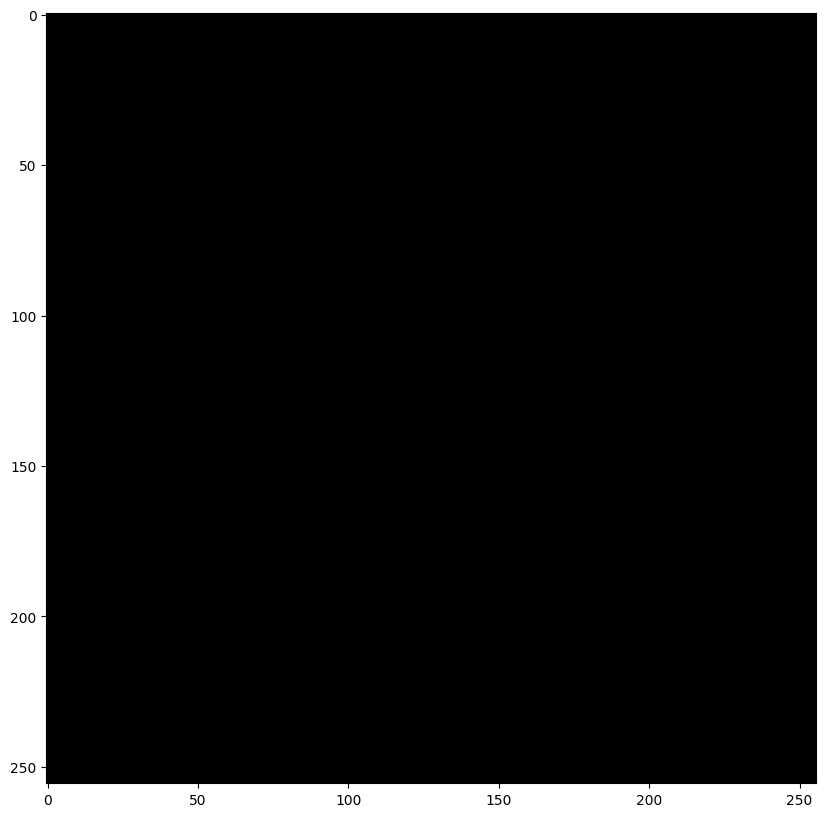

Classes in this image: ['tumor', 'non_tumor']


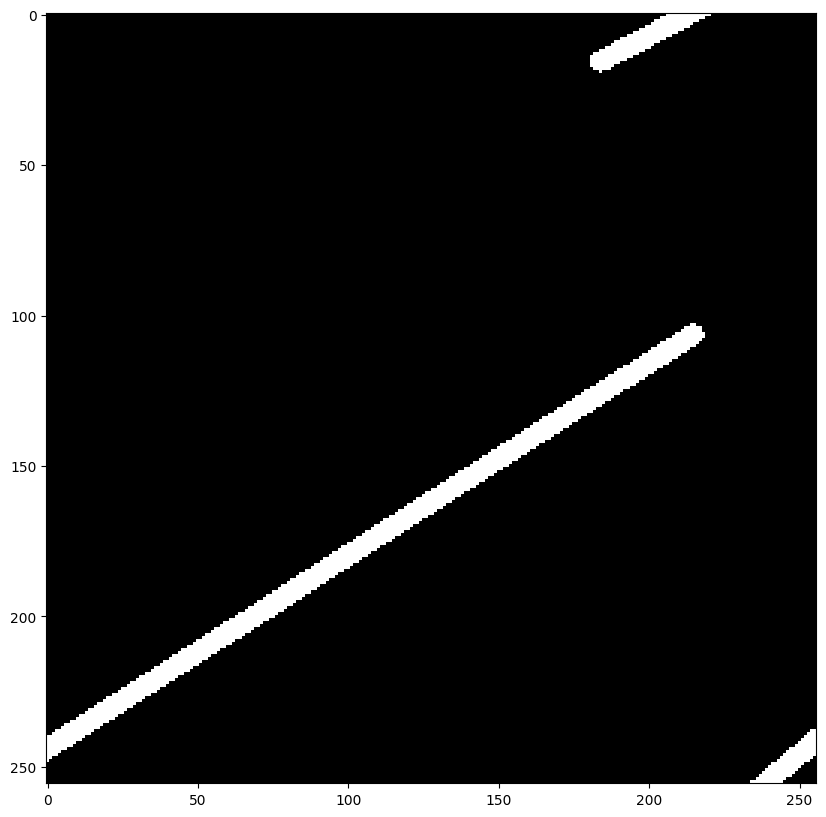

[0, 1]

In [78]:
############################################################################
# Inference
############################################################################

image = Image.open('../data/ovaskainen23/test/image/OG1_41_60.png').convert('RGB')
image

# prepare the image for the model
pixel_values = image_processor(
    image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

# forward pass
with torch.no_grad():
    outputs = model(pixel_values=pixel_values)

# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)


def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[0, 0, 0], [255, 255, 255]]


pred_segmentation_map = image_processor.post_process_semantic_segmentation(
  outputs, target_sizes=[image.size[::-1]])[0]
pred_segmentation_map = pred_segmentation_map.cpu().numpy()
print(pred_segmentation_map)

color_seg = np.zeros((pred_segmentation_map.shape[0],
                      pred_segmentation_map.shape[1], 3), dtype=np.uint8)

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[pred_segmentation_map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = color_seg
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

"""Compare this to the ground truth segmentation map:"""

map = Image.open('../data/ovaskainen23/test/gt/OG1_41_60.png').convert('L')
map

# convert map to NumPy array
map = np.array(map)
# map = np.array(np.array(map) < 0.5)
# map = Image.fromarray(np.uint8(map))
# map[map == 0] = 255 # background class is replaced by ignore_index
# map = map - 1 # other classes are reduced by one
map[map == 255] = 1

classes_map = np.unique(map).tolist()
unique_classes = ['tumor', 'non_tumor']
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8)
palette = np.array(ade_palette())

# for label, color in enumerate(palette):
    # color_seg[map == label, :] = color
    
# Convert to BGR
# color_seg = color_seg[..., ::-1]

# Show image + mask
# img = color_seg
img = map
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img, cmap='gray')
plt.show()

classes_map

In [79]:
pred_segmentation_map.shape, map.shape

((256, 256), (256, 256))

In [80]:
############################################################################
# Metrics
############################################################################

# metric expects a list of numpy arrays for both predictions and references
metrics = metric._compute(
                  predictions=[pred_segmentation_map],
                  references=[map],
                  num_labels=len(id2label),
                  reduce_labels=False,
                  ignore_index=333,
              )

metrics.keys()

# print overall metrics
for key in list(metrics.keys())[:3]:
    print(key, metrics[key])

# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()
for id, label in id2label.items():
    if id == 255: id = 1
    metric_table[label] = [
                           metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]
    ]

print("---------------------")
print("per-category metrics:")
pd.DataFrame.from_dict(metric_table, orient="index",
                       columns=["IoU", "accuracy"])

mean_iou 0.483001708984375
mean_accuracy 0.5
overall_accuracy 0.96600341796875
---------------------
per-category metrics:


,IoU,accuracy
non_frac,0.966003,1.0
frac,0.000000,0.0
